In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.environ['HOME_DIR'] = 'drive/MyDrive/hidden-networks'
!pip install -r $HOME_DIR/requirements.txt

import sys
sys.path.append(os.path.join('/content', os.environ['HOME_DIR']))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd
import collections

from simple_mnist_example import GetSubnet, SupermaskConv, SupermaskLinear
from simple_mnist_example import train, test, set_args

arg_list = ("batch_size", "test_batch_size", "epochs", "lr", 
            "momentum", 'wd', 'no_cuda', 'seed', 
            'log_interval', 'save_name', 'data', 
            'sparsity')

ArgClass = collections.namedtuple('ArgClass', list(arg_list))

In [ ]:
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.conv1 = SupermaskConv(1, 32, 3, 1, bias=False)
        self.conv2 = SupermaskConv(32, 64, 3, 1, bias=False)
        self.fc1 = SupermaskLinear(9216, 128, bias=True)
        self.fc2 = SupermaskLinear(128, 10, bias=False)
        self.args = args

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def get_extra_state(self):
        return self.args
      
    def set_extra_state(self, state):
        self.args = state

In [1]:
# The main function runs the full training loop on the MNIST dataset

def main(args):
    args = ArgClass(**args)

    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using device {device}")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.join(args.data, 'mnist'), train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    for i,j in enumerate(train_loader):
      print(j.shape)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.join(args.data, 'mnist'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = Net(args).to(device)
    # NOTE: only pass the parameters where p.requires_grad == True to the optimizer! Important!
    optimizer = optim.SGD(
        [p for p in model.parameters() if p.requires_grad],
        lr=args.lr,
        momentum=args.momentum,
        weight_decay=args.wd,
    )
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs)
    for epoch in range(1, args.epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, criterion, train_loader, name="Train")
        test(model, device, criterion, test_loader, name="Test")
        scheduler.step()

    if args.save_name is not None:
        torch.save(model.state_dict(), os.path.join(os.environ['HOME_DIR'], \
                                                    "trained_networks", args.save_name))
    
    return model

def get_prune_mask(layer, sparsity):
    with torch.no_grad():
        return GetSubnet.apply(layer.scores.abs(), sparsity)


def get_sign(weight):
  if weight > 0:
    return 1
  elif weight < 0:
    return -1
  else:
    return 0

def process_weight(weight):
  return abs(weight).item(), get_sign(weight)

def featurize_fc(weights, masks, sparsity, layer):
  weights = torch.transpose(weights, 0, 1)
  masks = torch.transpose(masks, 0, 1)
  weights_padded = F.pad(weights, (1,1,1,1), "constant", 0)
  data_fc = []
  for input in range(1, weights_padded.shape[0] - 1):
    for output in range(1, weights_padded.shape[1] - 1):
      mag_0, sign_0 = process_weight(weights_padded[input][output])
      mag_1, sign_1 = process_weight(weights_padded[input-1][output])
      mag_2, sign_2 = process_weight(weights_padded[input+1][output])
      mag_3, sign_3 = process_weight(weights_padded[input][output-1])
      mag_4, sign_4 = process_weight(weights_padded[input][output+1])
      include = masks[input-1][output-1].item()
      data_fc.append([input - 1, output - 1, mag_0, mag_1, mag_2, mag_3, mag_4, sign_0, sign_1, sign_2, sign_3, sign_4, sparsity, "fc"+layer, include])
  return data_fc


def featurize_conv(weights, masks, sparsity, layer):
  weights_padded =  F.pad(weights, (1,1,1,1), "constant", 0)
  data_conv = []
  for channel_num, channel in enumerate(weights_padded):
    for row in range(1, channel.shape[0] - 1):
      for col in range(1, channel.shape[1] - 1):
        mag_0, sign_0 = process_weight(channel[row][col])
        mag_1, sign_1 = process_weight(channel[row-1][col-1])
        mag_2, sign_2 = process_weight(channel[row-1][col])
        mag_3, sign_3 = process_weight(channel[row-1][col+1])
        mag_4, sign_4 = process_weight(channel[row][col-1])
        mag_5, sign_5 = process_weight(channel[row][col+1])
        mag_6, sign_6 = process_weight(channel[row+1][col-1])
        mag_7, sign_7 = process_weight(channel[row+1][col])
        mag_8, sign_8 = process_weight(channel[row+1][col+1])
        include = masks[channel_num][row-1][col-1].item()
        data_conv.append([channel_num, row - 1, col - 1, mag_0, mag_1, mag_2, mag_3, mag_4, mag_5, mag_6, mag_7, mag_8, sign_0, sign_1, sign_2, sign_3, sign_4, sign_5, sign_6, sign_7, sign_8, sparsity, "conv"+layer, include])
  return data_conv


In [ ]:
import csv
from tqdm import tqdm
import pickle

In [ ]:
a = (model.fc1.weight * get_prune_mask(model.fc1, 0.2)).flatten().cpu().detach().numpy()
b = a[a!= 0]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
np.var(a)

6.536166e-05

In [ ]:
fc1_bias = model.fc1.bias

In [ ]:
np.var(b)

0.00032490795

In [ ]:
np.var(np.abs(b))

7.895464e-05

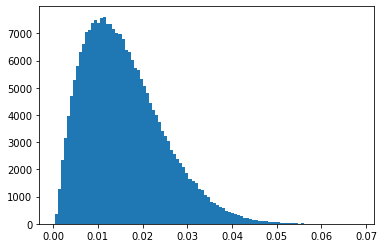

In [ ]:
plt.hist(np.abs(b), bins=100)
plt.show()

In [ ]:
b

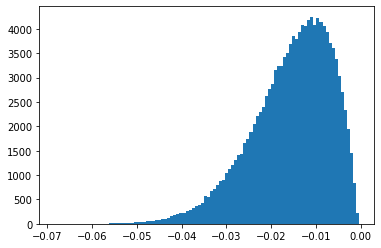

In [ ]:
plt.hist(b[b < 0], bins=100)
plt.show()

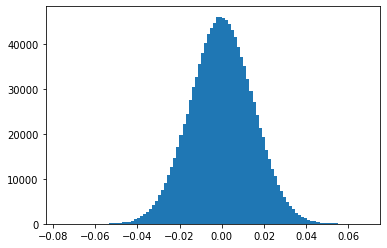

In [ ]:
plt.hist(fc1_weights.flatten().cpu().detach().numpy(), bins=100)
plt.show()

In [2]:
iter = 1
sparsity = 0.02
args = {
        "batch_size": 64, # input batch size for training (default: 64)
        "test_batch_size": 1000, # input batch size for testing (default: 1000)
        "epochs": 1, # number of epochs to train (default: 14)
        "lr": 0.1, # learning rate (default: 0.1)
        "momentum": 0.9, # Momentum (default: 0.9)
        'wd': 0.0005, # Weight decay (default: 0.0005)
        'no_cuda': False, # disables CUDA training
        'seed': iter, # random seed (default: 1)
        'log_interval': 10000, # how many batches to wait before logging training status
        'save_name': None, # For Saving the current Model, None if not saving
        'data': '../data', # Location to store data
        'sparsity': sparsity, # 'how sparse is each layer'
      }
model = main(args)
fc1_masks = get_prune_mask(model.fc1, sparsity)
fc1_weights = model.fc1.weight

NameError: ignored

In [ ]:
with tqdm(total=90) as pbar:
  for sparsity in [0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    for iter in range(10):
      args = {
        "batch_size": 64, # input batch size for training (default: 64)
        "test_batch_size": 1000, # input batch size for testing (default: 1000)
        "epochs": 1, # number of epochs to train (default: 14)
        "lr": 0.1, # learning rate (default: 0.1)
        "momentum": 0.9, # Momentum (default: 0.9)
        'wd': 0.0005, # Weight decay (default: 0.0005)
        'no_cuda': False, # disables CUDA training
        'seed': iter, # random seed (default: 1)
        'log_interval': 10000, # how many batches to wait before logging training status
        'save_name': None, # For Saving the current Model, None if not saving
        'data': '../data', # Location to store data
        'sparsity': sparsity, # 'how sparse is each layer'
      }

      model = main(args)
      conv1_masks = get_prune_mask(model.conv1, sparsity)
      conv1_weights = model.conv1.weight
      conv2_masks = get_prune_mask(model.conv2, sparsity)
      conv2_weights = model.conv2.weight
      fc1_masks = get_prune_mask(model.fc1, sparsity)
      fc1_weights = model.fc1.weight
      fc2_masks = get_prune_mask(model.fc2, sparsity)
      fc2_weights = model.fc2.weight

      conv1_masks = conv1_masks.squeeze()
      conv1_weights = conv1_weights.squeeze()
      conv2_masks = conv1_masks.squeeze()
      conv2_weights = conv1_weights.squeeze()

      data = {}
      data["conv1"] = torch.stack((conv1_masks, conv1_weights))
      data["conv2"] = torch.stack((conv2_masks, conv2_weights))
      data["fc1"] = torch.stack((fc1_masks, fc1_weights))
      data["fc2"] = torch.stack((fc2_masks, fc2_weights))
      def write_pickle(path, d):
        with open(path,'wb+') as f:
            return pickle.dump(d, f, protocol = pickle.HIGHEST_PROTOCOL)

      write_pickle('./drive/MyDrive/hidden-networks/dataset/conv1_s02.pkl', data['conv1'])
      write_pickle('./drive/MyDrive/hidden-networks/dataset/conv2_s02.pkl', data['conv2'])
      write_pickle('./drive/MyDrive/hidden-networks/dataset/fc1_s02.pkl', data['fc1'])
      write_pickle('./drive/MyDrive/hidden-networks/dataset/fc2_s02.pkl', data['fc2'])

      # conv1_data = featurize_conv(conv1_weights, conv1_masks, sparsity, "1")
      # conv2_data = featurize_conv(conv2_weights, conv2_masks, sparsity, "2")
      # conv_data = conv1_data + conv2_data

      # with open("./drive/MyDrive/hidden-networks/dataset/conv.csv", "a+", newline="") as f:
      #   writer = csv.writer(f)
      #   writer.writerows(conv_data)

      # fc1_data = featurize_fc(fc1_weights, fc1_masks, sparsity, "1")
      # fc2_data = featurize_fc(fc2_weights, fc2_masks, sparsity, "2")
      # fc_data = fc1_data + fc2_data

      # with open("./drive/MyDrive/hidden-networks/dataset/fc.csv", "a+", newline="") as f:
      #   writer = csv.writer(f)
      #   writer.writerows(fc_data)
      pbar.update(1)

  0%|          | 0/90 [00:00<?, ?it/s]

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.273029

Train set: Average loss: 0.0519, Accuracy: 5073/60000 (8%)



  1%|          | 1/90 [00:47<1:11:11, 48.00s/it]


Test set: Average loss: 0.0033, Accuracy: 830/10000 (8%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 6.633084

Train set: Average loss: 0.0892, Accuracy: 6290/60000 (10%)



  2%|▏         | 2/90 [01:36<1:10:33, 48.11s/it]


Test set: Average loss: 0.0057, Accuracy: 1107/10000 (11%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.225490

Train set: Average loss: 0.0508, Accuracy: 4619/60000 (8%)



  3%|▎         | 3/90 [02:24<1:10:02, 48.31s/it]


Test set: Average loss: 0.0033, Accuracy: 795/10000 (8%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.880657

Train set: Average loss: 0.0626, Accuracy: 8540/60000 (14%)



  4%|▍         | 4/90 [03:13<1:09:16, 48.33s/it]


Test set: Average loss: 0.0040, Accuracy: 1468/10000 (15%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.492078

Train set: Average loss: 0.0706, Accuracy: 6258/60000 (10%)



  6%|▌         | 5/90 [04:00<1:08:10, 48.13s/it]


Test set: Average loss: 0.0045, Accuracy: 1040/10000 (10%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.448099

Train set: Average loss: 0.0747, Accuracy: 4634/60000 (8%)



  7%|▋         | 6/90 [04:48<1:07:10, 47.98s/it]


Test set: Average loss: 0.0048, Accuracy: 798/10000 (8%)

Using device cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.405391


  7%|▋         | 6/90 [05:16<1:13:44, 52.67s/it]


KeyboardInterrupt: ignored

In [ ]:
F.pad(torch.transpose(fc1_masks, 0, 1), (2,2,0,0), "constant", 0).shape

torch.Size([9216, 132])

In [ ]:
torch.transpose(fc1_masks, 0, 1).shape

torch.Size([9216, 128])

In [ ]:
conv2_weights.shape

torch.Size([32, 3, 3])

In [ ]:
model

Net(
  (conv1): SupermaskConv(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): SupermaskConv(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (fc1): SupermaskLinear(in_features=9216, out_features=128, bias=False)
  (fc2): SupermaskLinear(in_features=128, out_features=10, bias=False)
)

In [ ]:
df

NameError: ignored